<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Currency_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the required libraries*

In [1]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.3 MB/s eta 0:00:00


# Importing the required packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [3]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


# Dates for which data will be extracted

In [4]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [5]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

# Get USD to EUR  price data from YFinance

In [103]:
df_USD_EUR=getDataFromAPI("YFinance","EURUSD=X",FirstDay,CurrentDate).reset_index()
df_USD_EUR['Date'] = pd.to_datetime(df_USD_EUR['Date']).dt.date
df_USD_EUR.set_index('Date', inplace=True)
df_USD_EUR=df_USD_EUR.asfreq('b')
df_USD_EUR.Close=df_USD_EUR.Close.fillna(method='bfill')
df_USD_EUR['Original_USD_EUR_Price']=df_USD_EUR[['Close']]
df_USD_EUR=df_USD_EUR[['Original_USD_EUR_Price']]


1. seasonal : This component is very close to 0 indicating the lack of strong seasonal pattern
2. Trend : This is majority of the component and data fluctuates and shows pattern
3. resid : this is almost 0 ,which says after accounting for trend and seasonality , the reamning variation are very small

,seasonal,trend,resid,Original_USD_EUR_Price
Date,,,,
2019-01-01,0.000179,1.136338,0.012790,1.149306
2019-01-02,0.000044,1.138148,0.007979,1.146171
2019-01-03,0.000202,1.141488,-0.009879,1.131811
2019-01-04,-0.000125,1.141222,-0.001989,1.139108
2019-01-07,-0.000299,1.141109,0.000235,1.141044
...,...,...,...,...
2023-07-05,0.000044,1.089055,-0.000605,1.088495
2023-07-06,0.000202,1.090300,-0.004843,1.085658
2023-07-07,-0.000125,1.092157,-0.002968,1.089064


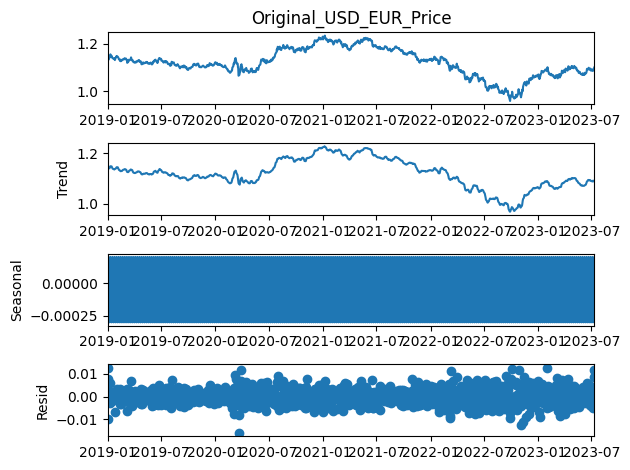

In [105]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df_USD_EUR['Original_USD_EUR_Price'], model='additive', extrapolate_trend='freq')
result_add.plot()
result_add_df=pd.concat([result_add.seasonal,result_add.trend,result_add.resid,result_add.observed],axis=1)
result_add_df

# To Detrending  the Timeseries I used  Moving Average of 5 days , I tried for multiple days but for 5 days I obseerved less Error .
# Also tried Log ,pct_change,diff method but moving average provided slightly better results

In [104]:
df_USD_EUR['Original_USD_EUR_Price_MA_5'] = df_USD_EUR['Original_USD_EUR_Price'].rolling(window=5,min_periods=1).mean()
df_USD_EUR

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5
Date,,
2019-01-01,1.149306,1.149306
2019-01-02,1.146171,1.147739
2019-01-03,1.131811,1.142429
2019-01-04,1.139108,1.141599
2019-01-07,1.141044,1.141488
...,...,...
2023-07-05,1.088495,1.089788
2023-07-06,1.085658,1.088603
2023-07-07,1.089064,1.089055


#Visualizing the Pattern

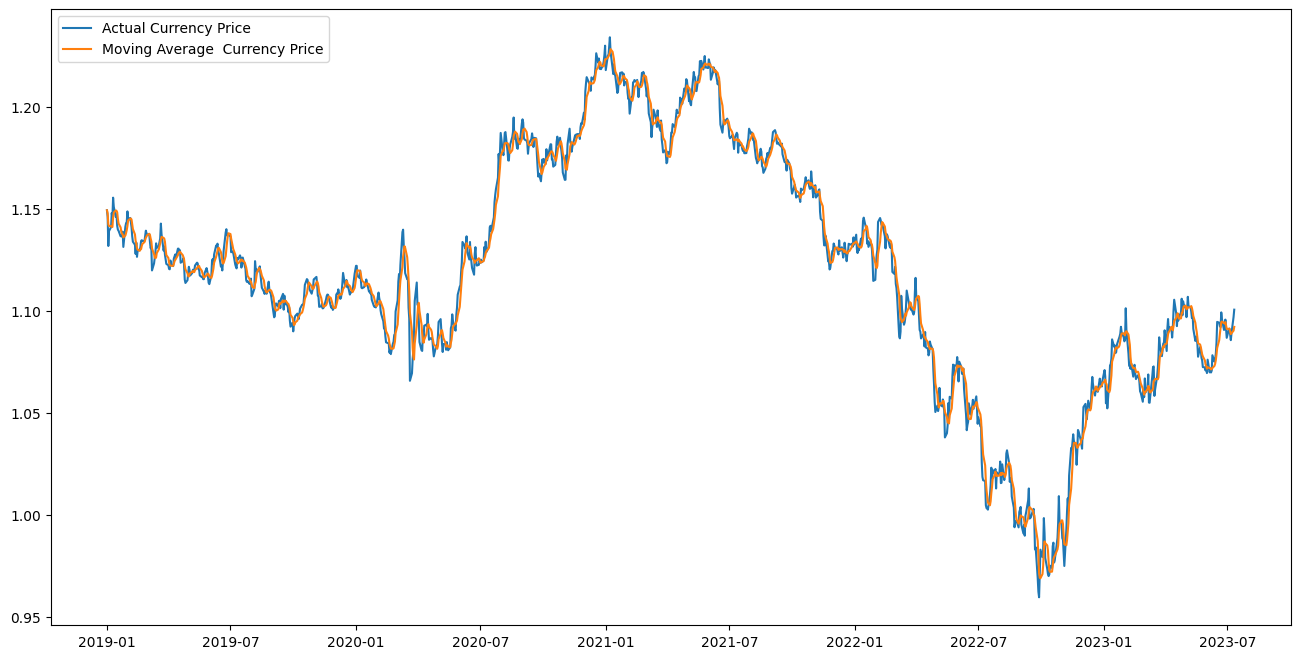

In [9]:
plt.figure(figsize=(16,8))
plt.plot(df_USD_EUR['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(df_USD_EUR['Original_USD_EUR_Price_MA_5'],label="Moving Average  Currency Price")
plt.legend(loc="upper left")

# Defining Training and Testing timeline
### Training Data From 2019-01-01 to 2022-12-31
### Testing Data from 2023-01-01 to Current Date

In [12]:
# Define the start and end dates for train and test data
train_end_date = pd.to_datetime('2022-12-31')


In [17]:
train_data_currency = df_USD_EUR[df_USD_EUR.index <= train_end_date]
test_data_currency = df_USD_EUR[df_USD_EUR.index > train_end_date]
train_data_currency.head(5)

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5
Date,,
2019-01-01,1.149306,1.149306
2019-01-02,1.146171,1.147739
2019-01-03,1.131811,1.142429
2019-01-04,1.139108,1.141599
2019-01-07,1.141044,1.141488


# Finding optimal values of p,d,q for ARIMA

## *   **AR term (p)**
This are lags of dependent variables. e.g. predictors for x(t) is x
(t-1) + x(t-2) + x(t-3).

## *   **Differentiation (d)**
This are number of occasions where we apply differentiation which helps to make time series stationary by removing trend.

## *   **MA term (q)**
This are lags for errors in prediction e.g. predictor for x(t) is e(t-1) + e(t-2) + e(t-3), where e(i) is the difference between the moving average value and the actual value.




#Check if data is stationary by doing differnce

In [18]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]

    # Print the results
    print("Augmented Dickey-Fuller Test:")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # Check the p-value against a significance level (e.g., 0.05) to determine stationarity
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")



In [19]:
perform_adfuller(train_data_currency['Original_USD_EUR_Price_MA_5'].diff(1).dropna())

Augmented Dickey-Fuller Test:
Test Statistic: -5.789427565946438
P-value: 4.911716257983335e-07
The time series is stationary.


In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def plot_acf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(data.dropna(), lags=lags, ax=ax,zero=False)
    plt.title('ACF')
    plt.show()

def plot_pacf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_pacf(data.dropna(), lags=lags, ax=ax,zero=False,alpha=0.05)
    plt.title('PACF')
    plt.show()


# Verifying the lags which can be selected for Training the model
##The lag value where the chart crosses the confidence interval for the first time can be good starting to point to select values of P(ACF) and Q(PACF)

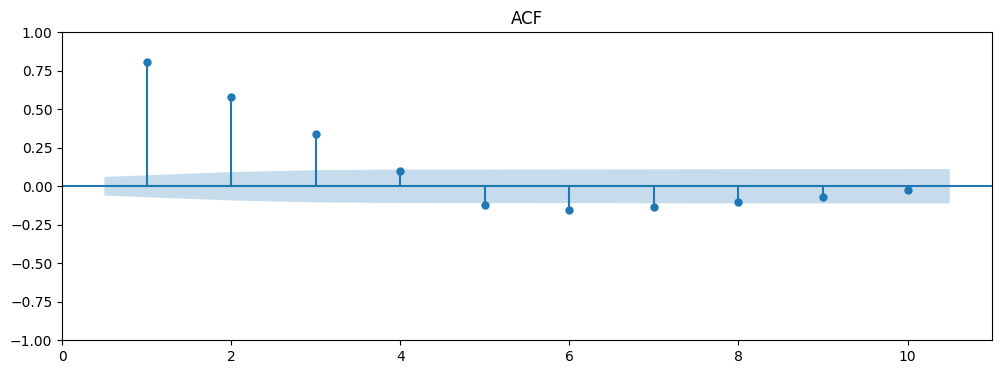

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


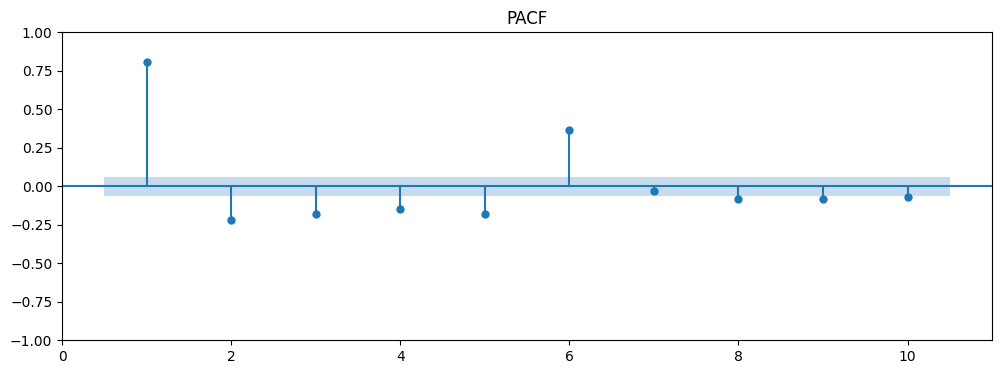

In [21]:
plot_acf_values(train_data_currency['Original_USD_EUR_Price_MA_5'].diff(1),10)
plot_pacf_values(train_data_currency['Original_USD_EUR_Price_MA_5'].diff(1),10)

# Auto Arima to find values of p,d,q

In [64]:
model = auto_arima(train_data_currency['Original_USD_EUR_Price_MA_5'].dropna(),
                    seasonal=False,   # No Seasonality
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10844.314, Time=3.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9700.722, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10807.025, Time=1.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9160.732, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9701.435, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10844.183, Time=1.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10828.290, Time=3.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-10779.616, Time=4.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-10898.435, Time=6.93 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-10844.317, Time=5.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-10883.563, Time=5.51 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-11186.567, Time=5.76 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-11206.213, Time=5.97 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-11298.367, Time=3.64 sec
 ARIMA(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:               SARIMAX(0, 1, 4)   Log Likelihood                5655.184
Date:                Wed, 12 Jul 2023   AIC                         -11298.367
Time:                        08:34:36   BIC                         -11268.668
Sample:                    01-01-2019   HQIC                        -11287.103
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.747e-05      0.000     -0.644      0.519      -0.000       0.000
ma.L1          0.9658      0.020     49.010      0.000       0.927       1.004
ma.L2          0.8764      0.024     36.756      0.000       0.830       0.923
ma.L3          0.8972      0.026     34.317      0.000       0.846       0.948
ma.L4          0.8199      0.020     41.020      0.000       0.781       0.859
sigma2      1.127e-06   3.85e-08     29.255      0.000    1.05e-06     1.2e-06
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):               209.00
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
import warnings
warnings.filterwarnings("ignore")


# After verifying manually diffrent values for p,d,q , along with what was observed from plot_acf and plot_pacf . The p,d,q values found based on ACF and PACF plot gave marginally better result compare to p,d,q values recived from AUTO ARIMA

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

cur_model=SARIMAX(train_data_currency['Original_USD_EUR_Price_MA_5'],order=(2,1,4))
cur_model_fit=cur_model.fit(maxiter=1000)
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     Original_USD_EUR_Price_MA_5   No. Observations:                 1044
Model:                        SARIMAX(2, 1, 4)   Log Likelihood                5591.605
Date:                         Wed, 12 Jul 2023   AIC                         -11169.210
Time:                                 08:36:14   BIC                         -11134.561
Sample:                             01-01-2019   HQIC                        -11156.068
                                  - 12-30-2022                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4567      0.057      8.074      0.000       0.346       0.568
ar.L2         -0.2637      0.047     -5.645      0.000      -0.355      -0.172
ma.L1          0.4895      0.051      9.630      0.000       0.390       0.589
ma.L2          0.7263      0.029     25.219      0.000       0.670       0.783
ma.L3          0.6599      0.027     24.696      0.000       0.607       0.712
ma.L4          0.5671      0.034     16.499      0.000       0.500       0.635
sigma2      1.284e-06   4.56e-08     28.151      0.000     1.2e-06    1.37e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               232.91
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Things to verifiy in optimal model selection
### 1) Log Likelihood ==> Higher the log value better the model is performing.
### 2) AIC , BIC, HQIC --> This are information criteria whcih states lower the criteria better is the model.

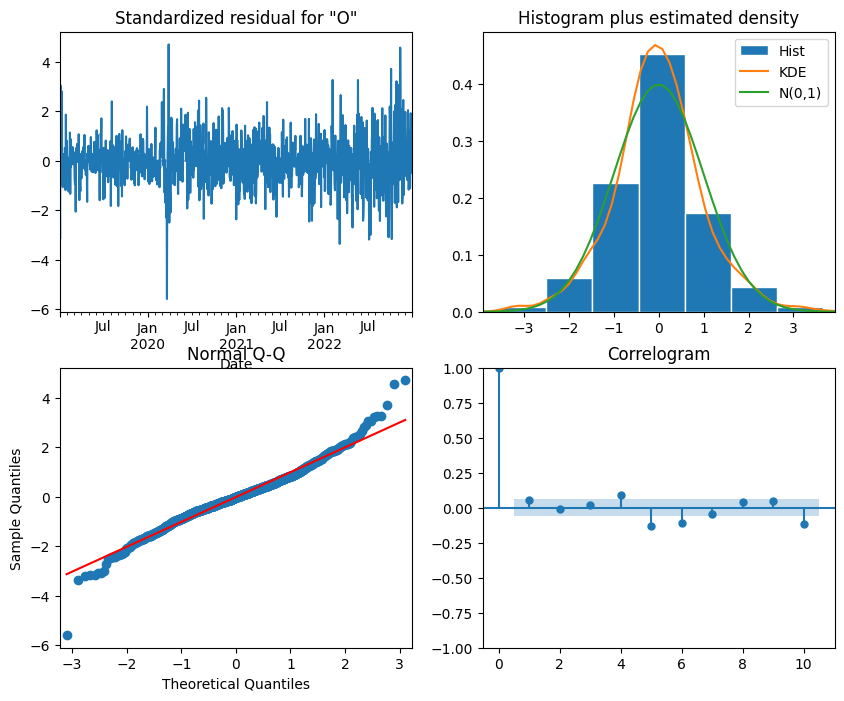

In [68]:
cur_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


### **1. Standardized Residulal** : This residual doesnt show any pattern and are randomly distributed around zero.
### **2. Histogram Plust esitmeted density** : Residuals are normally distriuted
### **3. Normal Q-Q Plot** : Most of the are along red line
### **4. Correlogram** : Its and ACF plot of residuals at diffrent lag and its mostly surrounded near 0
### To confirm plotted residual ACF and no lags were observed

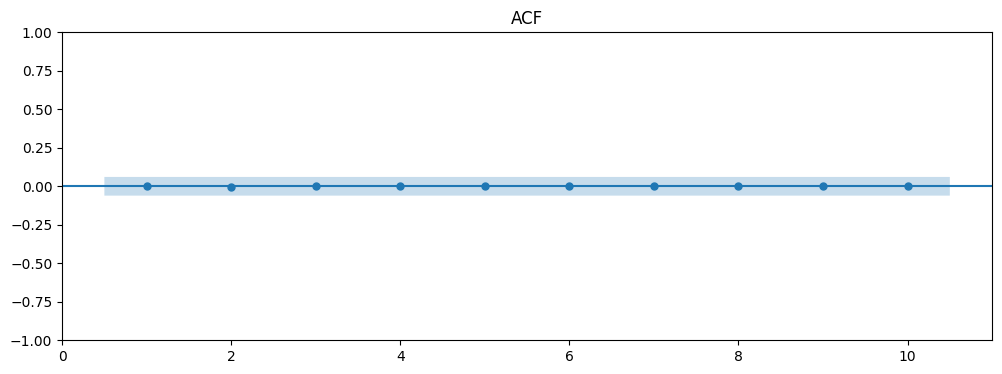

In [69]:
reid=cur_model_fit.resid
plot_acf_values(reid,10)


# Predicting the result for In sample Prediction

In [70]:
# Get in-sample predictions
training_data_predictions = cur_model_fit.get_prediction(start=train_data_currency.dropna().index.min(),
                                                      end=train_data_currency.dropna().index.max(),
                                                      dynamic=False)

train_data_currency[['lower Cur predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_currency['Cur predictions'] = training_data_predictions.predicted_mean

train_data_currency

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,lower Cur predictions,Higher Oil predictions,Cur predictions
Date,,,,,
2019-01-01,1.149306,1.149306,-1959.963985,1959.963985,0.000000
2019-01-02,1.146171,1.147739,1.145069,1.153543,1.149306
2019-01-03,1.131811,1.142429,1.143968,1.148983,1.146475
2019-01-04,1.139108,1.141599,1.135265,1.140223,1.137744
2019-01-07,1.141044,1.141488,1.138666,1.143563,1.141115
...,...,...,...,...,...
2022-12-26,1.066780,1.062456,1.058180,1.062503,1.060341
2022-12-27,1.064022,1.062969,1.061036,1.065359,1.063198
2022-12-28,1.063717,1.063172,1.061416,1.065739,1.063577


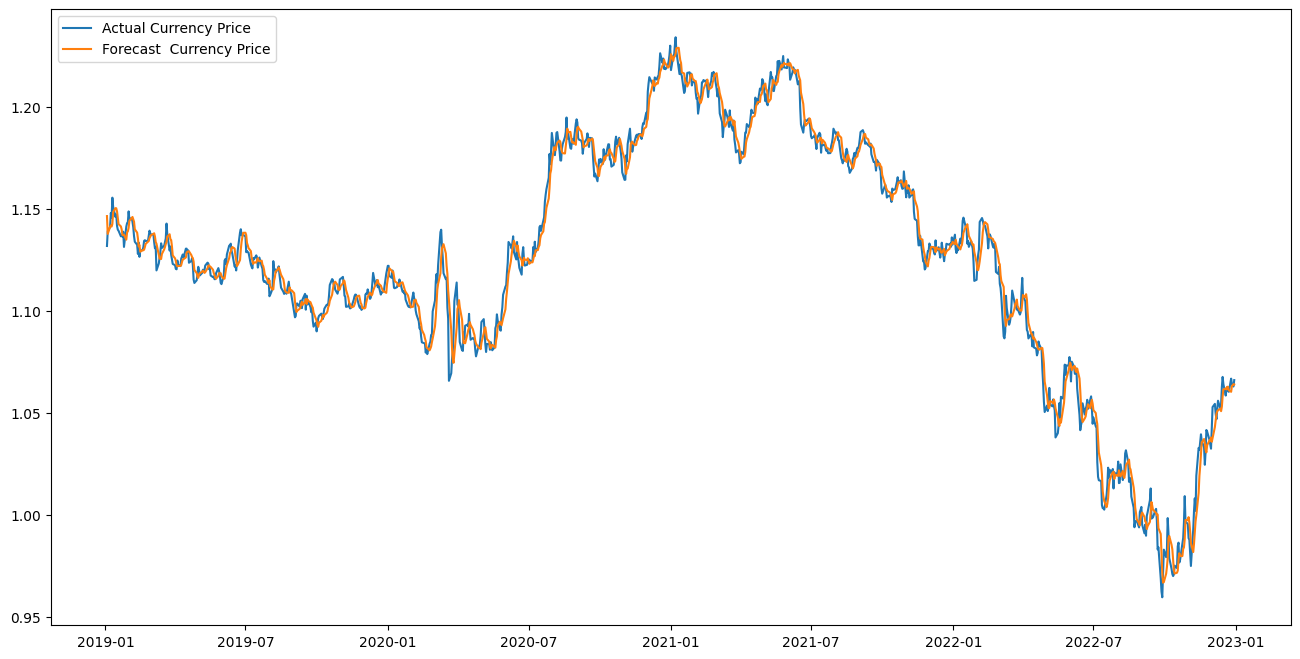

In [71]:
plt.figure(figsize=(16,8))
plt.plot(train_data_currency['Original_USD_EUR_Price'][2:],label="Actual Currency Price")
plt.plot(train_data_currency['Cur predictions'][2:],label="Forecast  Currency Price")
plt.legend(loc="upper left")

# Testing Started

# Approach 1

 ## I used the trained model to forecast one/five days ahead. After each forecast, I retrained the model, incorporating the actual test data for that day/five days. This process was repeated for each subsequent day/five days in the testing period

# One Day Steap Ahead -Walk-Forward Validation



In [77]:


# define model configuration
my_order = (2,1,4)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_currency['Original_USD_EUR_Price_MA_5']]
for i in range(len(test_data_currency['Original_USD_EUR_Price_MA_5'])):
    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True,d=2)
    #my_order = auto.order
    model = SARIMAX(history, order=my_order)
    model_fit = model.fit(maxiter=1000)
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    history.append(test_data_currency['Original_USD_EUR_Price'][i])
    #print("my_order is {} for date {} and predicted value is {} and actual value is {} ".format(my_order,test_data_currency['Original_USD_EUR_Price_MA_5'].index[i],forecast.predicted_mean[0],test_data_currency['Original_USD_EUR_Price_MA_5'][test_data_currency['Original_USD_EUR_Price_MA_5'].index[i]]))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_currency['Original_USD_EUR_Price'].index)



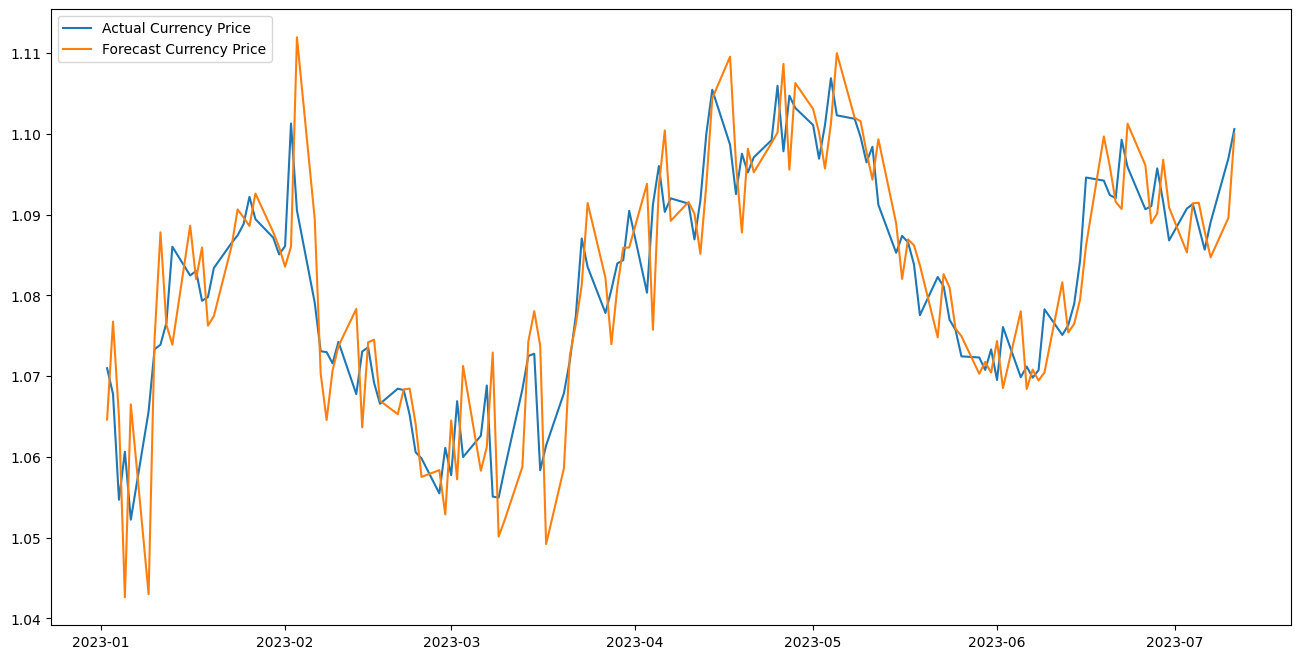

In [78]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [75]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}



# Calcualate metrics of model for One Day Forecasting

In [79]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'].dropna(), forecast_df['Forecast'].dropna())
metrics

{'Mean Absolute Error': 0.005389884062320191,
 'Mean Squared Error': 4.9446565249472975e-05,
 'Root Mean Squared Error': 0.0070318251719929,
 'Mean Absolute Percentage Error': 0.4993840492714124}

# Five Day Steap Ahead -Walk-Forward Validation



In [86]:
# define model configuration
my_order = (2,1,4)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_currency['Original_USD_EUR_Price_MA_5']]
for i in range(0,len(test_data_currency['Original_USD_EUR_Price_MA_5']),5):

    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True,d=2)
    #my_order = auto.order
    model = SARIMAX(history, order=my_order)
    model_fit = model.fit(maxiter=1000)

    # if less than 5 steps remaining, adjust steps to fit
    steps = min(5, len(test_data_currency['Original_USD_EUR_Price_MA_5']) - i)
    forecast = model_fit.get_forecast(steps=steps, alpha=0.05)
    forecasts.extend(forecast.predicted_mean)  # using extend instead of append

    # Append all forecasted values to the history
    history.extend(test_data_currency['Original_USD_EUR_Price'][i:i+steps])
    #print("my_order is {} for Week Starting {} and predicted value is {} and actual value is {}".format(my_order,test_data_currency['Original_USD_EUR_Price_MA_5'].index[i],test_data_currency['Original_USD_EUR_Price_MA_5'][i:i+steps],test_data_currency['Original_USD_EUR_Price_MA_5'][test_data_currency['Original_USD_EUR_Price_MA_5'].index[i:i+steps]].values.tolist()))

forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_currency['Original_USD_EUR_Price'].index)



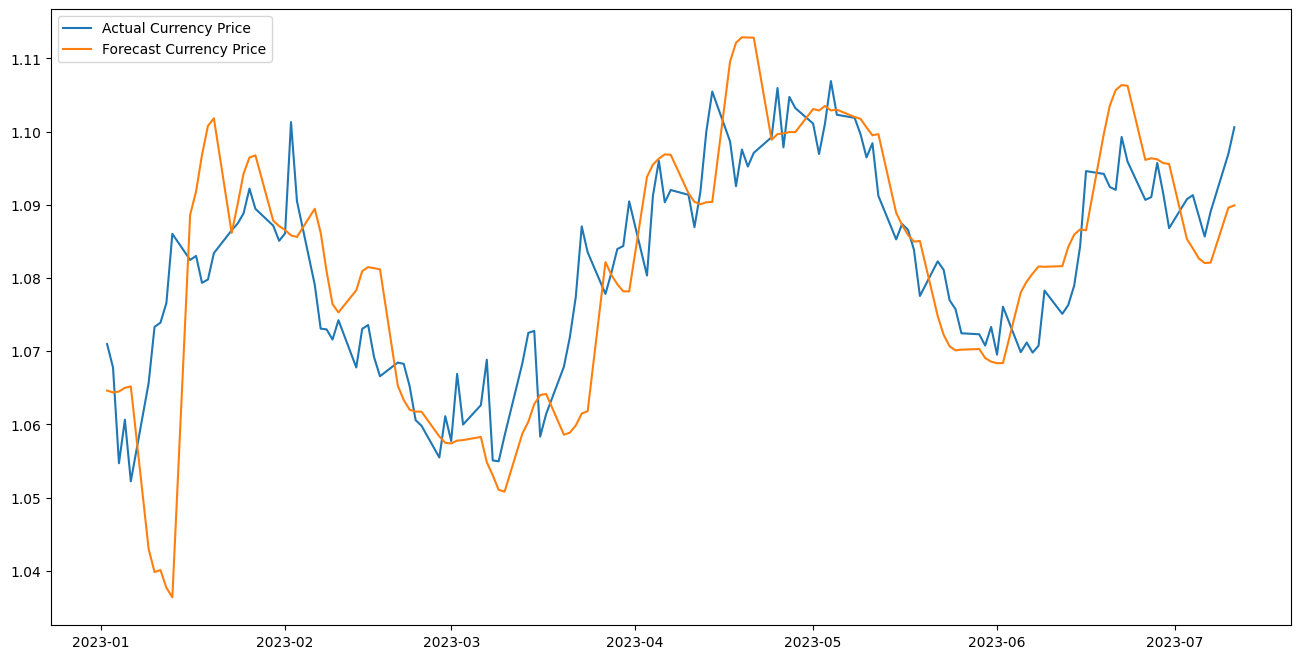

In [87]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


# Calcualate metrics of model for Five Day Forecasting

In [88]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'].dropna(), forecast_df['Forecast'].dropna())
metrics

{'Mean Absolute Error': 0.00788454339620305,
 'Mean Squared Error': 0.00012035344421580037,
 'Root Mean Squared Error': 0.010970571736049145,
 'Mean Absolute Percentage Error': 0.7293443530124575}

# Approach 2

 ## I followed a similar process to the first one. However, instead of incorporating actual test data for retraining the model, I included the forecasted data from the previous prediction.


In [92]:


my_order = (2,1,4)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_currency['Original_USD_EUR_Price_MA_5']]
for i in range(len(test_data_currency['Original_USD_EUR_Price_MA_5'])):
    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True,d=2)
    #my_order = auto.order
    model = SARIMAX(history, order=my_order)
    model_fit = model.fit(maxiter=1000)
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    history.append(forecast.predicted_mean[0])
    #print("my_order is {} for date {} and predicted value is {} and actual value is {} ".format(my_order,test_data_currency['Original_USD_EUR_Price_MA_5'].index[i],forecast.predicted_mean[0],test_data_currency['Original_USD_EUR_Price_MA_5'][test_data_currency['Original_USD_EUR_Price_MA_5'].index[i]]))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_currency['Original_USD_EUR_Price'].index)



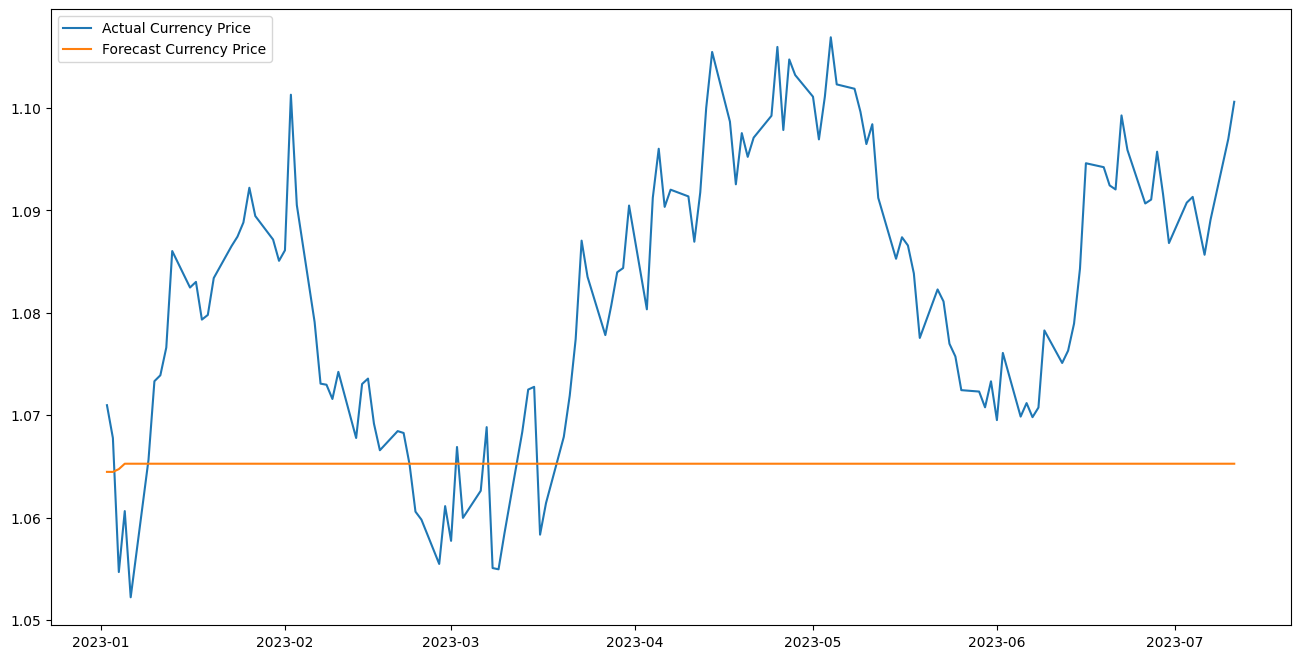

In [93]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [94]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'].dropna(), forecast_df['Forecast'].dropna())
metrics

{'Mean Absolute Error': 0.017995270396323926,
 'Mean Squared Error': 0.000450726258521348,
 'Root Mean Squared Error': 0.02123031461192575,
 'Mean Absolute Percentage Error': 1.6517361944645845}

# Approach 3

 ## I utilized the trained model to execute a multi-step ahead forecast for the entire testing period using the model_fit.get_forecast(steps=len(test_data)) function. Here, the length of the test data corresponded to the entire duration of 2023, which is close to 137 days of data.

In [95]:
testing_data_forecast = cur_model_fit.get_forecast(steps=len(test_data_currency), alpha=0.05)


# Create a new dataframe to hold the forecast
test_data_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_data_currency['Cur predictions'] =  testing_data_forecast.predicted_mean


test_data_currency

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,lower Cur predictions,Higher Cur predictions,Cur predictions
Date,,,,,
2023-01-02,1.070973,1.065543,1.062304,1.066627,1.064465
2023-01-03,1.067771,1.066292,1.059736,1.069185,1.064461
2023-01-04,1.054685,1.064486,1.056967,1.072502,1.064734
2023-01-05,1.060637,1.064028,1.054159,1.076363,1.065261
2023-01-06,1.052222,1.061258,1.050717,1.079804,1.065261
...,...,...,...,...,...
2023-07-05,1.088495,1.089788,0.957975,1.172547,1.065261
2023-07-06,1.085658,1.088603,0.957564,1.172957,1.065261
2023-07-07,1.089064,1.089055,0.957155,1.173366,1.065261


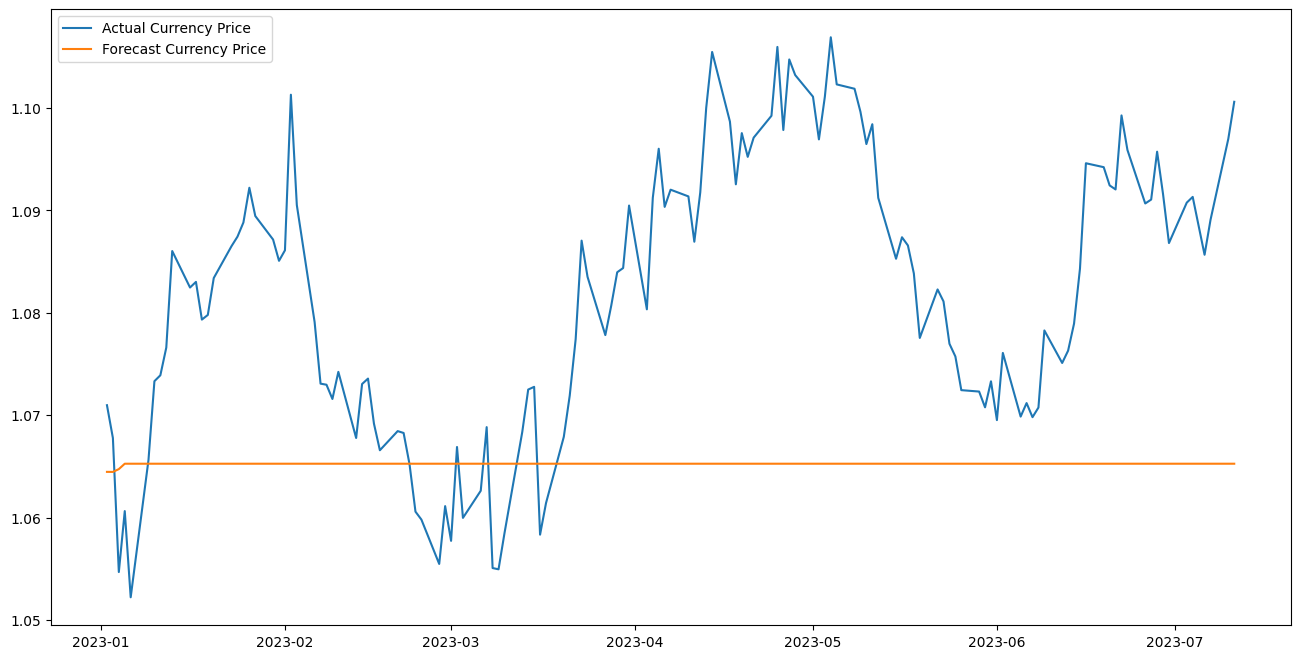

In [96]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_data_currency['Cur predictions'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [97]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'], test_data_currency['Cur predictions'])
metrics

{'Mean Absolute Error': 0.017994697025300162,
 'Mean Squared Error': 0.0004507015577187242,
 'Root Mean Squared Error': 0.021229732869697728,
 'Mean Absolute Percentage Error': 1.6516835117576667}

# As the forecast increases , error increases

##First 5 days

In [100]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'][:5], test_data_currency['Cur predictions'][:5])
metrics

{'Mean Absolute Error': 0.007506188144219416,
 'Mean Squared Error': 6.913859625056432e-05,
 'Root Mean Squared Error': 0.008314962191769986,
 'Mean Absolute Percentage Error': 0.7091397433706306}

##First 10 days

In [101]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'][:10], test_data_currency['Cur predictions'][:10])
metrics

{'Mean Absolute Error': 0.008669719045238545,
 'Mean Squared Error': 0.00010450029129765816,
 'Root Mean Squared Error': 0.010222538397954697,
 'Mean Absolute Percentage Error': 0.8100434864380991}

##First 15 days

In [102]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'][:15], test_data_currency['Cur predictions'][:15])
metrics

{'Mean Absolute Error': 0.01122489882494837,
 'Mean Squared Error': 0.0001595723908688604,
 'Root Mean Squared Error': 0.012632196597142573,
 'Mean Absolute Percentage Error': 1.0433789811152798}